# Reuters Newswire: Multi-class Classification

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from keras.datasets import reuters
from keras import models, layers

Using TensorFlow backend.


# 1. Data

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

We can check the size of the training and test sets.

In [3]:
print("Training set size: %s" %len(train_data))
print("Test set size: %s" %len(test_data))

Training set size: 8982
Test set size: 2246


As with the IDMB reviews, each sample is a list of word indices that we can decode.

In [4]:
train_data[10:12]

array([list([1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]),
       list([1, 56, 141, 5618, 1607, 149, 8, 16, 33, 223, 231, 336, 7, 37, 38, 459, 1017, 97, 916, 1077, 22, 1271, 19, 89, 16, 8, 4, 455, 33, 45, 30, 2265, 9376, 6, 255, 231, 1025, 4, 49, 8, 43, 10, 447, 5, 329, 1118, 307, 5, 25, 280, 189, 55, 2129, 7, 4, 214, 212, 17, 12])],
      dtype=object)

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# note indices are offset by 3 as first 3 are reserved for padding, start of sequence and unknown
# if word is not in index, then show '???'
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '???') for i in train_data[11]])
decoded_newswire

'??? lt international thomson organisation ltd said it will report financial results in u s funds rather than sterling beginning from jan 1 1987 it said the change will not be applied retroactively to prior financial periods the company said as a result of recent investments most of its assets now are located in the united states reuter 3'

We can also look at the relative occurrence of the various topics.

In [6]:
y = np.bincount(train_labels)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[   0,   55],
       [   1,  432],
       [   2,   74],
       [   3, 3159],
       [   4, 1949],
       [   5,   17],
       [   6,   48],
       [   7,   16],
       [   8,  139],
       [   9,  101],
       [  10,  124],
       [  11,  390],
       [  12,   49],
       [  13,  172],
       [  14,   26],
       [  15,   20],
       [  16,  444],
       [  17,   39],
       [  18,   66],
       [  19,  549],
       [  20,  269],
       [  21,  100],
       [  22,   15],
       [  23,   41],
       [  24,   62],
       [  25,   92],
       [  26,   24],
       [  27,   15],
       [  28,   48],
       [  29,   19],
       [  30,   45],
       [  31,   39],
       [  32,   32],
       [  33,   11],
       [  34,   50],
       [  35,   10],
       [  36,   49],
       [  37,   19],
       [  38,   19],
       [  39,   24],
       [  40,   36],
       [  41,   30],
       [  42,   13],
       [  43,   21],
       [  44,   12],
       [  45,   18]])

There are 46 topics with topic 35 being the rarest with only 10 occurrences.

## 1.1. Data Manipulation
Given that each list has differing lengths, we can prepare the data in two ways:
    - pad lists so they are the same length
    - one-hot encode each sequence into a 10,000-D vector
We choose the latter approach.

In [7]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Similarly, to vectorize the labels we cam:
- cast the label as an integer
- one-hot encode each labels into a 46-D vector

In [8]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

# Alternatively, we could use keras to do this
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

# 2. Defining Network Architecture
As we have a large number of output classes (i.e. 46), we need a relatively large number of hidden units in each layer. This ensures that we don't have an information bottleneck. We define a densely-connected network with the final layer having a softmax output. This ensures the network outputs a probability distribution over the 46 classes.

In [9]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

We choose to minimize categorical crossentropy (i.e. minimize distance between ground-truth probability distributions of the labels and the probability distribution predicted by the neural network).

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Training the model
We set aside 1,000 of the 8,982 training examples for validation.

In [11]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

We can now train the model.

In [12]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 101us/step - loss: 2.6690 - accuracy: 0.5160 - val_loss: 1.7068 - val_accuracy: 0.6310
Epoch 2/20
7982/7982 [==============================] - 1s 85us/step - loss: 1.3890 - accuracy: 0.7121 - val_loss: 1.2777 - val_accuracy: 0.7200
Epoch 3/20
7982/7982 [==============================] - 1s 86us/step - loss: 1.0211 - accuracy: 0.7844 - val_loss: 1.1077 - val_accuracy: 0.7610
Epoch 4/20
7982/7982 [==============================] - 1s 80us/step - loss: 0.7973 - accuracy: 0.8296 - val_loss: 1.0046 - val_accuracy: 0.7770
Epoch 5/20
7982/7982 [==============================] - 1s 79us/step - loss: 0.6375 - accuracy: 0.8624 - val_loss: 0.9583 - val_accuracy: 0.7950
Epoch 6/20
7982/7982 [==============================] - 1s 81us/step - loss: 0.5096 - accuracy: 0.8916 - val_loss: 0.9225 - val_accuracy: 0.8080
Epoch 7/20
7982/7982 [==============================] - 1s 83us/step - loss: 0.41

We can monitor how the accuracy and the categorical cross-entropy vary with epochs over both the training and the validation sets.

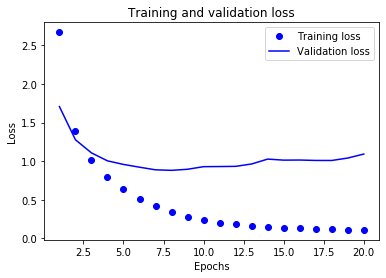

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The validation loss is minimized after 8 epochs of training. Let us examine how accuracy varies.

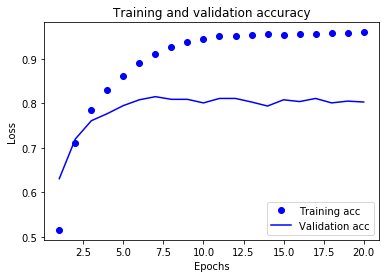

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 3.1. Test set performance
Based on the plots above, the network begins to overfit after 9 epochs.

In [15]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 91us/step - loss: 2.6641 - accuracy: 0.5264 - val_loss: 1.7671 - val_accuracy: 0.6250
Epoch 2/9
7982/7982 [==============================] - 1s 83us/step - loss: 1.4497 - accuracy: 0.7027 - val_loss: 1.3154 - val_accuracy: 0.7200
Epoch 3/9
7982/7982 [==============================] - 1s 83us/step - loss: 1.0570 - accuracy: 0.7816 - val_loss: 1.1476 - val_accuracy: 0.7500
Epoch 4/9
7982/7982 [==============================] - 1s 78us/step - loss: 0.8270 - accuracy: 0.8240 - val_loss: 1.0484 - val_accuracy: 0.7710
Epoch 5/9
7982/7982 [==============================] - 1s 82us/step - loss: 0.6526 - accuracy: 0.8601 - val_loss: 0.9666 - val_accuracy: 0.8040
Epoch 6/9
7982/7982 [==============================] - 1s 78us/step - loss: 0.5178 - accuracy: 0.8929 - val_loss: 0.9246 - val_accuracy: 0.8180
Epoch 7/9
7982/7982 [==============================] - 1s 83us/step - loss: 0.4151 - acc

We can then evaluate the model results.

In [16]:
results = model.evaluate(x_test, one_hot_test_labels)
results

2246/2246 [==============================] - 0s 64us/step


[0.9976062732197192, 0.7871772050857544]

An accuracy of ~80% is achieved. How does this compare to a purely random classifier?

In [17]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.19056099732858414

We see that the the random classifier only achieves ~18% accuracy... much less than the 79% achieved by the neural network!

# 4. Model Performance with other Factors
## 4.1. Encoding of Labels
Instead of one-hot encoding, we can instead choose to cast the label as integers.

In [18]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In this case, we should rather use a 'sparse categorical cross-entropy' (instead of 'categorical cross-entropy').

In [19]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)
results

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 77us/step - loss: 0.2636 - accuracy: 0.9411 - val_loss: 0.9309 - val_accuracy: 0.8110
Epoch 2/9
7982/7982 [==============================] - 0s 60us/step - loss: 0.1947 - accuracy: 0.9514 - val_loss: 1.0019 - val_accuracy: 0.8010
Epoch 3/9
7982/7982 [==============================] - 0s 58us/step - loss: 0.1810 - accuracy: 0.9518 - val_loss: 0.9654 - val_accuracy: 0.8060
Epoch 4/9
7982/7982 [==============================] - 0s 56us/step - loss: 0.1655 - accuracy: 0.9526 - val_loss: 0.9875 - val_accuracy: 0.8120
Epoch 5/9
7982/7982 [==============================] - 0s 57us/step - loss: 0.1490 - accuracy: 0.9536 - val_loss: 1.0048 - val_accuracy: 0.8070
Epoch 6/9
7982/7982 [==============================] - 0s 59us/step - loss: 0.1349 - accuracy: 0.9558 - val_loss: 1.0135 - val_accuracy: 0.8080
Epoch 7/9
7982/7982 [==============================] - 0s 60us/step - loss: 0.1291 - acc

[1.1770084819301154, 0.7925200462341309]

The model achieves effectively the same accuracy as the previous one. This is expected as 'sparse_categorial_crossentropy' is mathematically identical to 'categorical_crossentropy'. We are just using a different interface. Let's revert back to the original data.

In [20]:
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## 4.2. Model Architecture
We shall both examine how the performance varies as we change the number of hidden layers and the number of units in each layer.

### 4.2.1. Number of Units
Let us vary the number of hidden units whilst keeping the number of hidden layers at 2 and the number of epochs to train with based on the optimum validation loss.

In [21]:
nUnits = [32, 64, 128]

loss_values = np.zeros(len(nUnits))
val_loss_values = np.zeros(len(nUnits))
acc_values = np.zeros(len(nUnits))
val_acc_values = np.zeros(len(nUnits))
for i, n in enumerate(nUnits):
    model = models.Sequential()
    model.add(layers.Dense(n, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(n, activation='relu'))
    model.add(layers.Dense(46, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    h = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                  validation_data=(x_val, y_val), verbose=0)
    h = h.history
    
    minInd = np.argmin(h['val_loss'])
    
    loss_values[i] = h['loss'][minInd]
    val_loss_values[i] = h['val_loss'][minInd]
    acc_values[i] = h['accuracy'][minInd]
    val_acc_values[i] = h['val_accuracy'][minInd]
    
    print("[# Units: %s, Optimum Epochs: %s, Validation Loss: %s, Validation Accuracy: %s]"
          %(n, minInd + 1, val_loss_values[i], val_acc_values[i]))


[# Units: 32, Optimum Epochs: 14, Validation Loss: 0.9408710441589355, Validation Accuracy: 0.8109999895095825]
[# Units: 64, Optimum Epochs: 8, Validation Loss: 0.8910752620697021, Validation Accuracy: 0.8209999799728394]
[# Units: 128, Optimum Epochs: 6, Validation Loss: 0.854744662284851, Validation Accuracy: 0.8289999961853027]


We see that having 64 hidden units is the optimum for validation loss and accuracy. Let us see what would occur if we kept the first layer at 64 hidden units but compress the second layer to 4 hidden units.

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 68us/step - loss: 3.4185 - accuracy: 0.0034 - val_loss: 3.0791 - val_accuracy: 0.0050
Epoch 2/20
7982/7982 [==============================] - 0s 62us/step - loss: 2.8499 - accuracy: 0.0764 - val_loss: 2.6618 - val_accuracy: 0.2420
Epoch 3/20
7982/7982 [==============================] - 1s 73us/step - loss: 2.3598 - accuracy: 0.4127 - val_loss: 2.1749 - val_accuracy: 0.5420
Epoch 4/20
7982/7982 [==============================] - 1s 72us/step - loss: 1.9223 - accuracy: 0.5482 - val_loss: 1.8936 - val_accuracy: 0.5440
Epoch 5/20
7982/7982 [==============================] - 1s 73us/step - loss: 1.6872 - accuracy: 0.5763 - val_loss: 1.7469 - val_accuracy: 0.5700
Epoch 6/20
7982/7982 [==============================] - 1s 73us/step - loss: 1.5344 - accuracy: 0.5950 - val_loss: 1.6491 - val_accuracy: 0.5760
Epoch 7/20
7982/7982 [==============================] - 1s 73us/step - loss: 1.420

In [23]:
results = model.evaluate(x_test, one_hot_test_labels)
results

2246/2246 [==============================] - 0s 53us/step


[1.4761854196804927, 0.6896705031394958]

Due to the information bottleneck in the second layer, the performance deteriorates from ~78% in the original model to ~69% here.

### 4.2.2. Number of Layers

We shall try between 1 and 3 hidden layers.  In all cases, we shall train on the optimum number of epochs (according to the validated loss) and use 64 hidden units.

In [24]:
nLayers = np.arange(1, 4, 1)

loss_values = np.zeros(len(nLayers))
val_loss_values = np.zeros(len(nLayers))
acc_values = np.zeros(len(nLayers))
val_acc_values = np.zeros(len(nLayers))
for i, n in enumerate(nLayers):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
    if n > 1:
        for i in range(n - 1):
            model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(46, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    h = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                  validation_data=(x_val, y_val), verbose=0)
    h = h.history
    
    minInd = np.argmin(h['val_loss'])
    
    loss_values[i] = h['loss'][minInd]
    val_loss_values[i] = h['val_loss'][minInd]
    acc_values[i] = h['accuracy'][minInd]
    val_acc_values[i] = h['val_accuracy'][minInd]
    
    print("[# Layers: %s, Optimum Epochs: %s, Validation Loss: %s, Validation Accuracy: %s]"
          %(n, minInd + 1, val_loss_values[i], val_acc_values[i]))


[# Layers: 1, Optimum Epochs: 10, Validation Loss: 0.8197776393890381, Validation Accuracy: 0.8209999799728394]
[# Layers: 2, Optimum Epochs: 7, Validation Loss: 0.8643952832221985, Validation Accuracy: 0.8190000057220459]
[# Layers: 3, Optimum Epochs: 8, Validation Loss: 0.9922438554763794, Validation Accuracy: 0.7960000038146973]


We see that having two hidden layers is indeed optimum.